In [1]:
%load_ext autoreload
%autoreload 2

### The original notebook, as got from Danit

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
#from costcla.metrics import cost_loss, savings_score
# from costcla.models import CostSensitiveDecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import random
import math
from sklearn.feature_selection import mutual_info_classif
import pickle
import timeit

In [3]:
from ada_csl_wrc.legacy import *

In [4]:
df = pd.read_csv('data/marketing_campaign.csv', sep=";")
df = df.drop(['Z_CostContact', 'Z_Revenue', 'Income', 'Dt_Customer', 'ID'], axis = 1)
categorial_col = df.columns.drop(df.describe().columns)
for col in categorial_col:
    df[col] = df[col].astype('category').cat.codes

category_col = []
for col in df.columns:
#     print(col)
#     print(df[col].value_counts().shape[0])
    if df[col].value_counts().shape[0] < 3:
        category_col.append(col)
category_col

X = df.drop(labels = 'Response', axis=1)
y = df['Response']

In [5]:
mask_cat_col = []
for col in X.columns:
    if col in category_col:
        mask_cat_col.append(True)
    else:
        mask_cat_col.append(False)
mask_cat_col

mutual_info = mutual_info_classif(X, y, discrete_features=mask_cat_col, n_neighbors=3, copy=True, random_state=41)
mutual_info

array([8.80601382e-03, 2.54551689e-03, 0.00000000e+00, 0.00000000e+00,
       1.96628618e-02, 2.42494947e-02, 4.14050997e-02, 1.39431650e-02,
       5.22633828e-02, 9.18862998e-03, 1.41310034e-03, 2.87678212e-02,
       1.06650101e-02, 2.05330323e-02, 2.79378261e-02, 4.29813388e-03,
       8.45201813e-03, 2.37630991e-02, 1.22757562e-02, 3.75929348e-02,
       3.04818699e-02, 9.38244534e-03, 1.47386329e-06])

In [8]:
len(mask_cat_col)

23

In [10]:
cfn = 10
cfp = 1
t = cfp/(cfp+cfn)
constraint = [int(x) for x in range(27,140)] # uptade the constraint range to be between 0.25*P to 1.25*P
X = X.to_numpy()
y = y.to_numpy()
#accuracy based model
clf_dt = DecisionTreeClassifier()
max_depth = [3, 5, 10, 15]
criterion = ['gini','entropy']
min_samples_leaf = [10, 15, 20, 30]
param_grid = {'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}
pprint(param_grid)
grid_search = GridSearchCV(estimator = clf_dt, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2)
grid_search.fit(X,y)
print(grid_search.best_params_)
clf_dt = grid_search.best_estimator_
grid_search.best_params_

best_combination = [15, 5, True, 0.001] # for CS-DT

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [30]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

In [9]:
X = df.drop(labels = 'Response', axis=1)
y = df['Response']


# drop columns
worst_features =[]
for i,v in enumerate(mutual_info):
    if v in sorted(mutual_info)[:17]: # update to 0.75*num_of_features
        worst_features.append(i)
print(worst_features)
X_17 = X.iloc[:, worst_features]
X_17 = X_17.to_numpy()

worst_features =[]
for i,v in enumerate(mutual_info):
    if v in sorted(mutual_info)[:11]: # update to 0.5*num_of_features
        worst_features.append(i)
print(worst_features)
X_11 = X.iloc[:, worst_features]
X_11 = X_11.to_numpy()

X = X.to_numpy()
y = y.to_numpy()
r = y*cfn +(1-y)*(-cfp)

[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 15, 16, 17, 18, 21, 22]
[0, 1, 2, 3, 9, 10, 12, 15, 16, 21, 22]


NameError: name 'cfn' is not defined

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# cost_mat_train_i = cost_mat(1,10,y_train)
# clf_cs_dt.fit(np.array(X_train),np.array(y_train), cost_mat_train_i)
# y_pred_proba_i= clf_cs_dt.predict_proba(np.array(X_train))
# y_pred_probs_i = [y_pred_proba_i[j][1] for j in range(len(y_pred_proba_i))]
# d_t_i = get_dynamic_threshold(y_pred_probs_i,100,0.5)

In [10]:
from ada_csl_wrc.models import CostSensitiveDecisionTreeClassifier

loaded ada_csl_wrc.utils


In [12]:
#apply the experimnt on differnt slices of the dataset
clf_cs_dt = CostSensitiveDecisionTreeClassifier(min_samples_leaf = best_combination[0], max_depth = best_combination[1],
                                              pruned = best_combination[2], min_gain = best_combination[3])

# for smoozing the graph - repeat the experiment with 10 different CV
random_state_list = [24]#, 6, 18, 32, 76, 5, 40, 12, 31, 9]
constraint = [50, 60]
result_dict_all, result_dict_075, result_dict_05 = {}, {}, {}
for random_state in random_state_list:
    print('********', random_state, '********')

    fold_dict_all = experiment(clf_cs_dt, clf_dt, random_state, X, y, cfp, cfn, constraint)
    result_dict_all[random_state] = fold_dict_all

#     fold_dict_075 = experiment(clf, clf_dt, random_state, X_17, y, r, cfp, cfn, constraint)
#     result_dict_075[random_state] = fold_dict_075

#     fold_dict_05 = experiment(clf, clf_dt, random_state, X_11, y, r, cfp, cfn, constraint)
#     result_dict_05[random_state] = fold_dict_05



******** 24 ********
1
c 50
break
c 60
break
2
c 50
break
c 60
break
3
c 50
break
c 60
break


In [29]:
clf_dt.predict_proba(X)

array([[0.93158388, 0.06841612],
       [0.93158388, 0.06841612],
       [0.93158388, 0.06841612],
       ...,
       [0.93158388, 0.06841612],
       [0.76888889, 0.23111111],
       [0.93158388, 0.06841612]])

In [26]:
result_dict_all[24][3]["dt"][0]

{'cost': 757.0,
 'cm':      0   1
 0  628   7
 1   75  36,
 'accuracy': 0.8900804289544236,
 'precision': 0.8372093023255814,
 'f_score': 0.4675324675324676,
 'time': 0.005468699964694679,
 'n_positive': 43}

In [14]:
# #save data
# with open('result_dict_05.pickle', 'wb') as handle:
#     pickle.dump(result_dict_05, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('result_dict_075.pickle', 'wb') as handle:
#     pickle.dump(result_dict_075, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('result_dict_all.pickle', 'wb') as handle:
#     pickle.dump(result_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# #load data
# #random_state_list = [24, 6, 18, 32, 76, 5, 40, 12, 31, 9]

# with open('marketing_result_dict_11_v2.pickle', 'rb') as handle:
#     marketing_result_dict_11 = pickle.load(handle)

# with open('marketing_result_dict_17_v2.pickle', 'rb') as handle:
#     marketing_result_dict_17 = pickle.load(handle)

# with open('marketing_result_dict_all_v2.pickle', 'rb') as handle:
#     marketing_result_dict_all = pickle.load(handle)

In [ ]:
pd.DataFrame(result_dict_all[24][1]['cs'])

,0,50,60
cost,473.0,1071.0,1059.0
cm,0 1 0 222 413 1 6 106,0 1 0 594 41 1 103 9,0 1 0 586 49 1 101 11
accuracy,0.43909,0.807229,0.799197
precision,0.204239,0.18,0.183333
f_score,0.335975,0.111111,0.127907
time,3.160641,3.16104,3.161013
n_positive,519.0,NaN,NaN
probs,NaN,"[0.0036231884057971015, 0.0036231884057971015,...","[0.0036231884057971015, 0.0036231884057971015,..."


In [ ]:
cs_measure, dt_measure, one_before_measure, itr_list = get_measure_list(result_dict_all, 'cost', random_state_list, constraint)

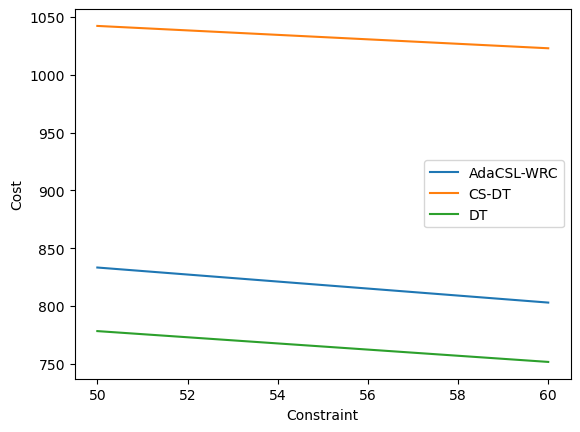

In [ ]:
plt.plot(constraint, get_mean_list(one_before_measure), label = 'AdaCSL-WRC')
plt.plot(constraint, get_mean_list(cs_measure), label = 'CS-DT')
plt.plot(constraint, get_mean_list(dt_measure), label = 'DT')
plt.ylabel('Cost')
plt.xlabel('Constraint')
plt.legend()
plt.show()

In [ ]:
!pip freeze

adjustText==0.7.3
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
alembic==1.11.1
anaconda-client==1.7.2
anaconda-navigator==2.4.2
anaconda-project==0.8.3
appdirs==1.4.4
apyori==1.1.2
argh==0.26.2
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569878360/work
asn1crypto @ file:///C:/ci/asn1crypto_1652344143274/work
astroid @ file:///C:/b/abs_d4lg3_taxn/croot/astroid_1676904351456/work
astropy @ file:///C:/ci/astropy_1657719688889/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///C:/b/abs_09s3y775ra/croot/attrs_1668696195628/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1596578164842/work
Babel @ file:///C:/b/abs_a2shv_3tqi/croot/babel_1671782804377/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools

regex @ file:///C:/ci/regex_1658258240596/work
requests @ file:///C:/b/abs_316c2inijk/croot/requests_1690400295842/work
retrying==1.3.3
rope @ file:///C:/b/abs_55g_tm_6ff/croot/rope_1676675029164/work
Rtree @ file:///C:/b/abs_e116ltblik/croot/rtree_1675157871717/work
ruamel_yaml==0.15.87
scikit-image==0.17.2
scikit-learn @ file:///C:/b/abs_55olq_4gzc/croot/scikit-learn_1690978955123/work
scipy==1.10.1
seaborn @ file:///tmp/build/80754af9/seaborn_1600553570093/work
Send2Trash @ file:///tmp/build/80754af9/send2trash_1632406701022/work
simplegeneric==0.8.1
singledispatch @ file:///tmp/build/80754af9/singledispatch_1629321204894/work
sip==4.19.13
six @ file:///tmp/build/80754af9/six_1644875935023/work
snowballstemmer @ file:///tmp/build/80754af9/snowballstemmer_1637937080595/work
sortedcollections @ file:///tmp/build/80754af9/sortedcollections_1611172717284/work
sortedcontainers @ file:///tmp/build/80754af9/sortedcontainers_1623949099177/work
soupsieve @ file:///C:/b/abs_a989exj3q6/croot/s